# Tratamiento de imágenes - 2023 - Entregable 3

# Fecha de entrega: 04/6/2023

### Importante:   
**En todos los ejercicios se espera que se presente un breve contexto teórico y se  hagan comentarios sobre decisiones tomadas en la implementación así como un análisis de los resultados. Estos comentarios y análisis se pueden entregar en secciones agregadas al notebook o en un informe aparte agregado al notebook.**   

**El notebook entregado debe tener guardados los resultados de su ejecución.**

In [38]:
import os
import numpy as np
import pandas as pd
from tabulate import tabulate
from matplotlib import pyplot as plt
import seaborn as sn
from skimage.io import imread, imsave
from skimage.feature import greycomatrix, greycoprops
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
# FORMAS DE VER LAS GRAFICAS --------------------
# ELEGIR UNA DE LAS OPCIONES Y DES-COMENTAR (sacar # de la linea)
# ----------------
# a) graficas en línea  entre las celdas (no interactivo)
%matplotlib inline
# ---------------- 
# b) graficas en línea  entre las celdas (interactivo)
# %matplotlib notebook
# ----------------
# c) graficas en ventanas externas (abre una ventana por cada figura)
# %matplotlib
# ----------------
# d) Si se usa "jupyter lab" en lugar de "jupyter notebook" usar %matplotlib widget en lugar de %matplotlib notebook 
# requiere instalar el modulo "ipympl". Ver https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab#56416229
# %matplotlib widget
#---------------------------------------------------



# Directorio con la base de imágenes de prueba (las que están en la web de Timag)
# Ej. si usan la imagen trapo.jpg en el notebook no tienen que subirla al eva
# La llaman en el notebook en forma relativa a donde tengan esas imagenes:
# 
# filename = os.path.join(dir_base_imagenes, 'trapo.jpg')
# I = imread(filename)
dir_base_imagenes = 'imagenes/'
dir_base_texturas = 'texturas/'



## 1. Clasificación de texturas

Se usará la base de datos
G. Kylberg. The Kylberg Texture Dataset v. 1.0, Centre for Image Analysis,
Swedish University of Agricultural Sciences and Uppsala University,
External report (Blue series) No. 35.  
Disponible en: http://www.cb.uu.se/~gustaf/texture/  
Bajar la versión reducida de la base (6 clases, 40 muestras por clase, ~50 MB)

### 1.1 Calcular descriptores de textura


#### Calcular descriptores sobre el histograma de niveles de gris

In [2]:
def mu_n(histograma, m, n):
    mu_n=0
    for i in range (256):
        mu_n=mu_n+((i-m)**n)*histograma[i]
    return mu_n

def calcular_descriptores_de_histograma(I):
    '''
    Calcula el histograma normalizado de la imagen I.
    Devuelve descriptores sobre el histograma calculado
    
    Parameters
    ----------
    I : imagen de 256 niveles de gris (uint8)

    Returns
    -------
    mean : double
    R : double
    skewness : double
    flatness : double
    uniformity : double
    entropy : double

    '''
    
    # calcular el histograma normalizado  
    numBins = 256
    histograma, bin_edges = np.histogram(I[:], np.arange(numBins+1), density=True)
    m=0
    entropy=0
    for i in range(numBins):
        m=m+i*histograma[i]
        if histograma[i]>0:
            entropy=entropy-(histograma[i]*np.log2(histograma[i]))
    mu2=mu_n(histograma, m,2)
    mu3=mu_n(histograma, m,3)
    mu4=mu_n(histograma, m,4)

    mean=m
    R=1-1/(1+mu2)
    skewness=mu3
    flatness=mu4
    uniformity = np.sum(histograma**2)
   
    return mean, R, skewness, flatness, uniformity, entropy

#### Calcular descriptores sobre la matriz de coocurrencia   
Para la implementación se usarán funciones adecuadas de   
https://scikit-image.org/docs/stable/api/skimage.feature.html

In [3]:
def calcular_descriptores_de_matriz_de_coocurrencia(I, distance, angle, levels=256, debug=False):
    '''
    Calcula la matriz de coocurrencia NORMALIZADA para la imagen I 
    para la combinación (distancia, angulo) deseado  
    Devuelve descriptores sobre la matriz de coocurrencia calculada
    Se implementa con funciones adecuadas de: 
        skimage.feature
       
    Parameters
    ----------
    I : imagen de 256 niveles de gris (uint8)
    distance : int, optional
        Distancia entre pixeles para calcular la coocurrencia.
    angle : double, optional
        Angulo (en radianes con respecto a la horizontal) para calcular la coocurrencia. 
    levels : int, optional . Por defecto 256.
        Usar solo para debuggear en imagenes artificiales pequeñas
    debug: bool, optional
        En caso de ser verdadero, imprime la matriz de coocurrencia 
    Returns
    -------
    contrast : double
    dissimilarity : double
    homogeneity : double
    energy : double
    correlation : double

    '''
    
    # COMPLETAR
    
    matriz_coocurrencia=greycomatrix(I, [distance], [angle],levels=levels)
    if debug:
        print("Matriz de coocurrencia:", matriz_coocurrencia)
    contrast = greycoprops(matriz_coocurrencia, 'contrast')
    dissimilarity = greycoprops(matriz_coocurrencia, 'dissimilarity')
    homogeneity = greycoprops(matriz_coocurrencia, 'homogeneity')
    energy = greycoprops(matriz_coocurrencia, 'energy')
    correlation = greycoprops(matriz_coocurrencia, 'correlation')

    return contrast, dissimilarity, homogeneity, energy, correlation


#### Chequear cálculo de descriptores sobre la matriz de coocurrencia
Chequear que la matriz de coocurrencia y los descriptores estén bien calculados sobre un caso sencillo con 4 niveles

In [10]:
image = np.array([[0, 0, 1, 1],
                  [0, 0, 1, 1],
                  [0, 2, 2, 2],
                  [2, 2, 3, 3]], dtype=np.uint8)

print("Descriptores de Histograma: ")
mean, R, skewness, flatness, uniformity, entropy=calcular_descriptores_de_histograma(image)
print("Mean: ", mean)
print("R: ", R)
print("Skewness: ", skewness)
print("Flatness: ", flatness)
print("Uniformity: ", uniformity)
print("Entropy: ", entropy)
print("\n")

# chequear funcionamiento de la función para distancia 1 horizontal y distancia 1 vertical
print("Distancia 1 horizontal:")
contrast, dissimilarity, homogeneity, energy, correlation=calcular_descriptores_de_matriz_de_coocurrencia(image, 1, 0, levels=256, debug=True)
print("Contrast: ", contrast)
print("Dissimilarity: ", dissimilarity)
print("Homogeneity: ", homogeneity)
print("Energy: ", energy)
print("Correlation: ", correlation)
    
print("\n")
print("Distancia 1 vertical:")
contrast, dissimilarity, homogeneity, energy, correlation=calcular_descriptores_de_matriz_de_coocurrencia(image, 1, np.pi/2, levels=256, debug=False)
print("Contrast: ", contrast)
print("Dissimilarity: ", dissimilarity)
print("Homogeneity: ", homogeneity)
print("Energy: ", energy)
print("Correlation: ", correlation)


Descriptores de Histograma: 
Mean:  1.25
R:  0.5151515151515151
Skewness:  0.1875
Flatness:  2.03515625
Uniformity:  0.2734375
Entropy:  1.9237949406953985


Distancia 1 horizontal:
Matriz de coocurrencia: [[[[2]]

  [[2]]

  [[1]]

  ...

  [[0]]

  [[0]]

  [[0]]]


 [[[0]]

  [[2]]

  [[0]]

  ...

  [[0]]

  [[0]]

  [[0]]]


 [[[0]]

  [[0]]

  [[3]]

  ...

  [[0]]

  [[0]]

  [[0]]]


 ...


 [[[0]]

  [[0]]

  [[0]]

  ...

  [[0]]

  [[0]]

  [[0]]]


 [[[0]]

  [[0]]

  [[0]]

  ...

  [[0]]

  [[0]]

  [[0]]]


 [[[0]]

  [[0]]

  [[0]]

  ...

  [[0]]

  [[0]]

  [[0]]]]
Contrast:  [[0.58333333]]
Dissimilarity:  [[0.41666667]]
Homogeneity:  [[0.80833333]]
Energy:  [[0.40824829]]
Correlation:  [[0.79698847]]


Distancia 1 vertical:
Contrast:  [[1.]]
Dissimilarity:  [[0.66666667]]
Homogeneity:  [[0.7]]
Energy:  [[0.42491829]]
Correlation:  [[0.70116959]]


#### Calcular descriptores de histograma y de matriz de coocurrencia sobre imágenes de la base de texturas.  Mostrar ejemplos para imágenes de las distintas clases

Para la matriz de coocurrencia puede ser conveniente explorar distintas distancias y ángulos


R=0 para zonas de intensidad constante
Skewness ~ simetría
Entropia ~ variabilidad

In [17]:
def calcular_descriptores(I, angulo, distancia, datos, textura):
    mean, R, skewness, flatness, uniformity, entropy=calcular_descriptores_de_histograma(I)
    contrast, dissimilarity, homogeneity, energy, correlation=calcular_descriptores_de_matriz_de_coocurrencia(I, distancia, angulo, levels=256, debug=False)
    datos.append([textura, mean, R, skewness, flatness, uniformity, entropy, contrast, dissimilarity, homogeneity, energy, correlation])
    return(datos)

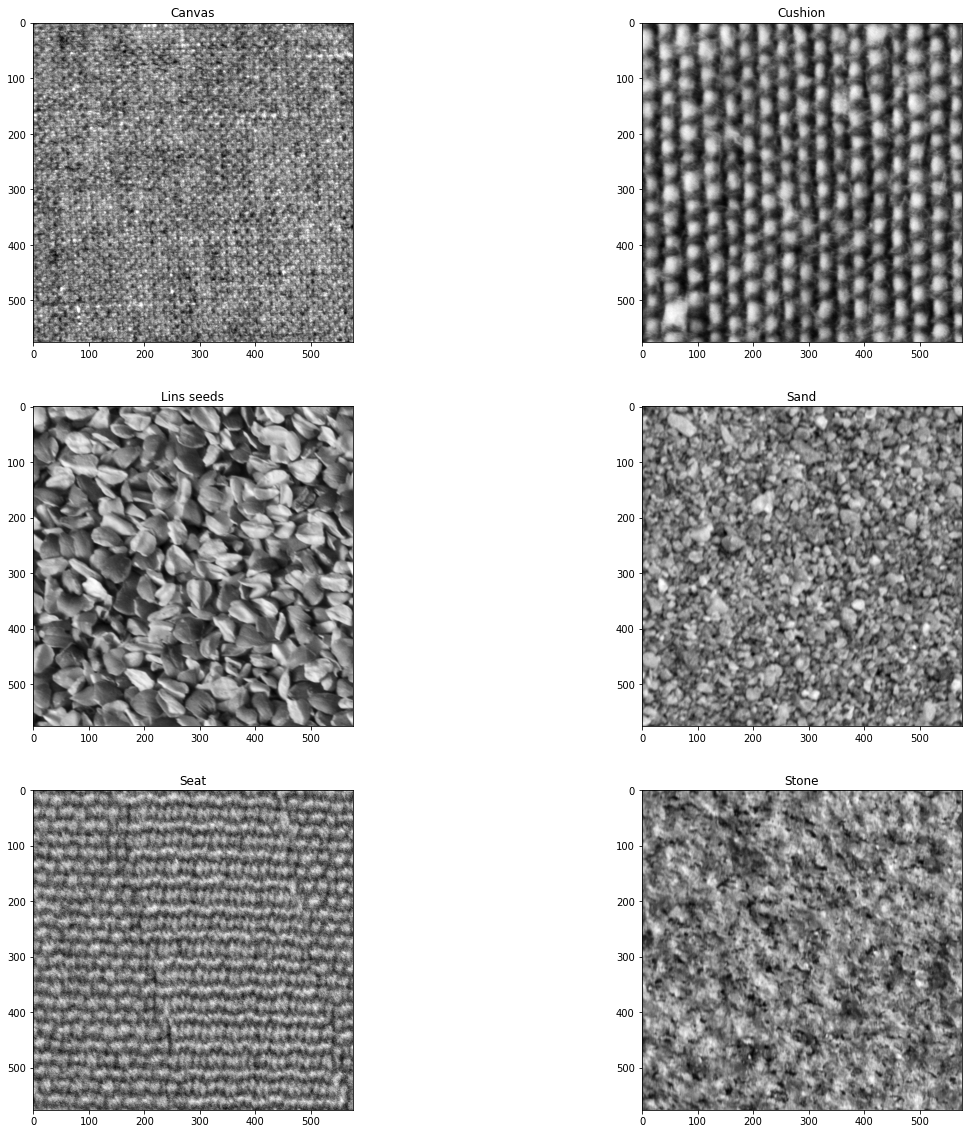

+------------+---------+----------+------------+-------------+--------------+-----------+------------+-----------------+---------------+------------+---------------+
| Textura    |    Mean |        R |   Skewness |    Flatness |   Uniformity |   Entropy |   Contrast |   Dissimilarity |   Homogeneity |     Energy |   Correlation |
+============+=========+==========+============+=============+==============+===========+============+=================+===============+============+===============+
| Canvas     | 126.921 | 0.999366 |  14566.2   | 7.593e+06   |   0.0193885  |   5.90552 |    3203.38 |         45.2532 |     0.0265729 | 0.0194795  |   -0.0195888  |
+------------+---------+----------+------------+-------------+--------------+-----------+------------+-----------------+---------------+------------+---------------+
| Cushion    | 126.998 | 0.999375 |  31155.5   | 5.832e+06   |   0.00774873 |   7.18447 |    4251.62 |         54.0766 |     0.0175334 | 0.00820245 |   -0.335056   |
+---

In [18]:

distancia=50
angulo=0
datos=[["Textura", "Mean", "R", "Skewness", "Flatness", "Uniformity", "Entropy", "Contrast", "Dissimilarity", "Homogeneity", "Energy", "Correlation"]]
I = cv2.imread(dir_base_texturas+"/canvas1/canvas1-a-p001.png")
I=I[:,:,0]
datos=calcular_descriptores(I, angulo, distancia, datos, "Canvas")
    

J = cv2.imread(dir_base_texturas+"/cushion1/cushion1-a-p001.png")
J=J[:,:,0]
datos=calcular_descriptores(J, angulo, distancia, datos, "Cushion")

    

fig, axs = plt.subplots(3,2,figsize=(20,20))
axs[0,0].imshow(I,cmap="gray")
axs[0,0].set_title('Canvas')
axs[0,1].imshow(J,cmap="gray")
axs[0,1].set_title('Cushion')



I = cv2.imread(dir_base_texturas+"/linsseeds1/linseeds1-a-p001.png")
I=I[:,:,0]
datos=calcular_descriptores(I, angulo, distancia, datos, "Lins Seeds")

J = cv2.imread(dir_base_texturas+"/sand1/sand1-a-p001.png")
J=J[:,:,0]
datos=calcular_descriptores(J, angulo, distancia, datos, "Sand")

axs[1,0].imshow(I,cmap="gray")
axs[1,0].set_title('Lins seeds')
axs[1,1].imshow(J,cmap="gray")
axs[1,1].set_title('Sand')


I = cv2.imread(dir_base_texturas+"/seat2/seat2-a-p001.png")
I=I[:,:,0]
datos=calcular_descriptores(I, angulo, distancia, datos, "Seat")

    

J = cv2.imread(dir_base_texturas+"/stone1/stone1-a-p001.png")
J=J[:,:,0]
datos=calcular_descriptores(J, angulo, distancia, datos, "Stone")

    

axs[2,0].imshow(I,cmap="gray")
axs[2,0].set_title('Seat')
axs[2,1].imshow(J,cmap="gray")
axs[2,1].set_title('Stone')


plt.show()

print(tabulate(datos, headers="firstrow", tablefmt="grid"))



### 1.2. Ver si algunos de los descriptores calculados permiten discriminar las texturas


#### Analizar gráficamente:  Considerar pares de descriptores. Graficar los valores para las imágenes de la base y ver si se separan las clases. 
Puede ser conveniente para esto explorar:  https://seaborn.pydata.org/generated/seaborn.pairplot.html


In [35]:
def procesar_carpeta_texturas(direccion, distancia, angulo):

    datos=[["Textura", "Mean", "R", "Skewness", "Flatness", "Uniformity", "Entropy", "Contrast", "Dissimilarity", "Homogeneity", "Energy", "Correlation"]]
    carpetas_texturas = os.listdir(direccion)
    
    for textura in carpetas_texturas:
        # Ruta completa de la carpeta de textura actual
        carpeta_textura_actual = os.path.join(direccion, textura)
        
        if os.path.isdir(carpeta_textura_actual):
            # Leer las imágenes en la carpeta de textura actual
            imagenes = os.listdir(carpeta_textura_actual)
            
            for imagen in imagenes:
                # Ruta completa de la imagen actual
                ruta_imagen = os.path.join(carpeta_textura_actual, imagen)
                
                if os.path.isfile(ruta_imagen):
                    I = cv2.imread(ruta_imagen)
                    I=I[:,:,0]
                    datos=calcular_descriptores(I, angulo, distancia, datos, textura)
                    
    return(datos)

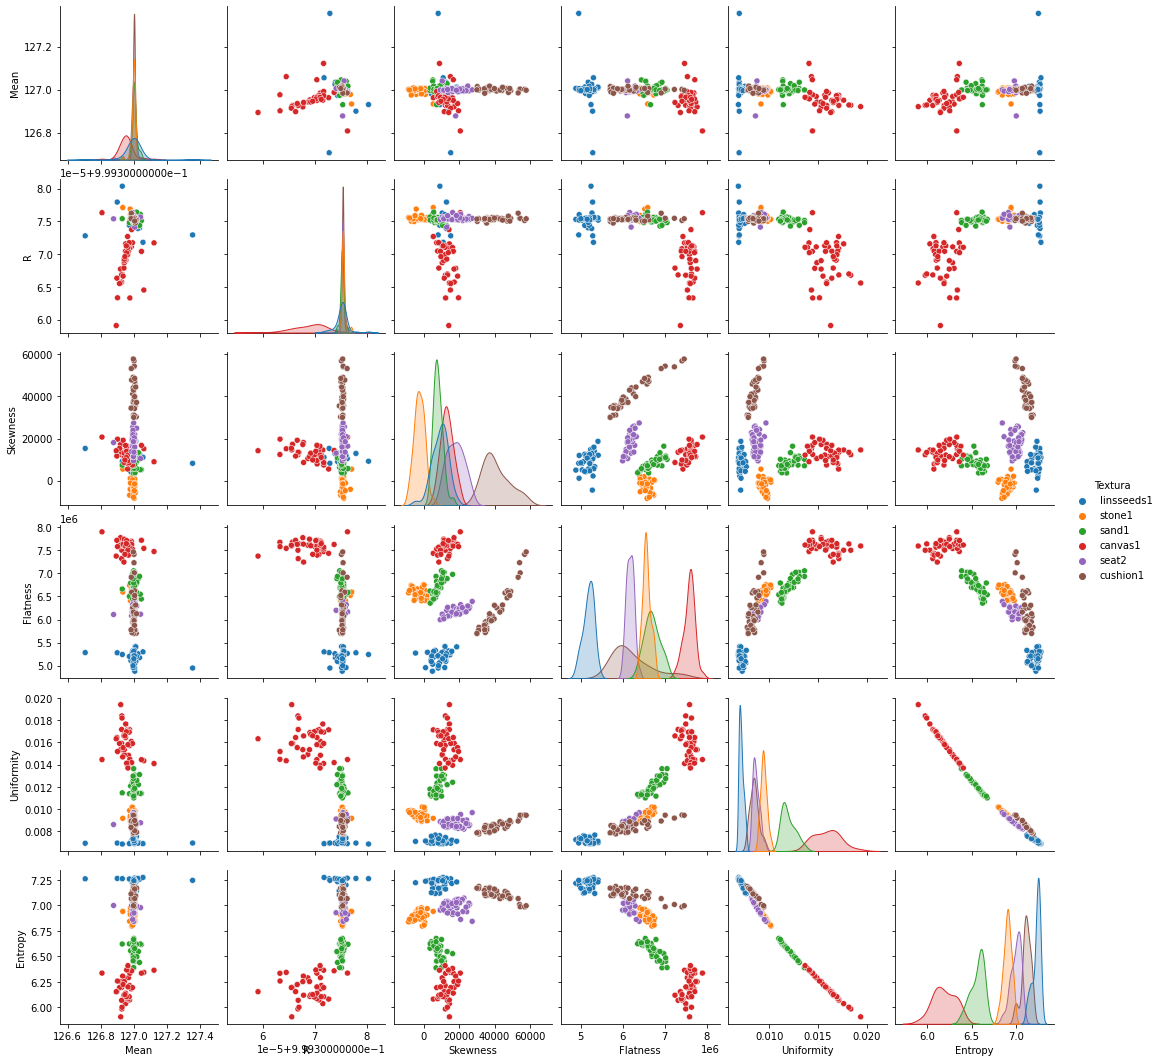

In [28]:
distancia=50
angulo=0
datos=procesar_carpeta_texturas(dir_base_texturas, distancia, angulo)
df = pd.DataFrame(datos[1:], columns=datos[0])
sn.pairplot(df, hue='Textura')

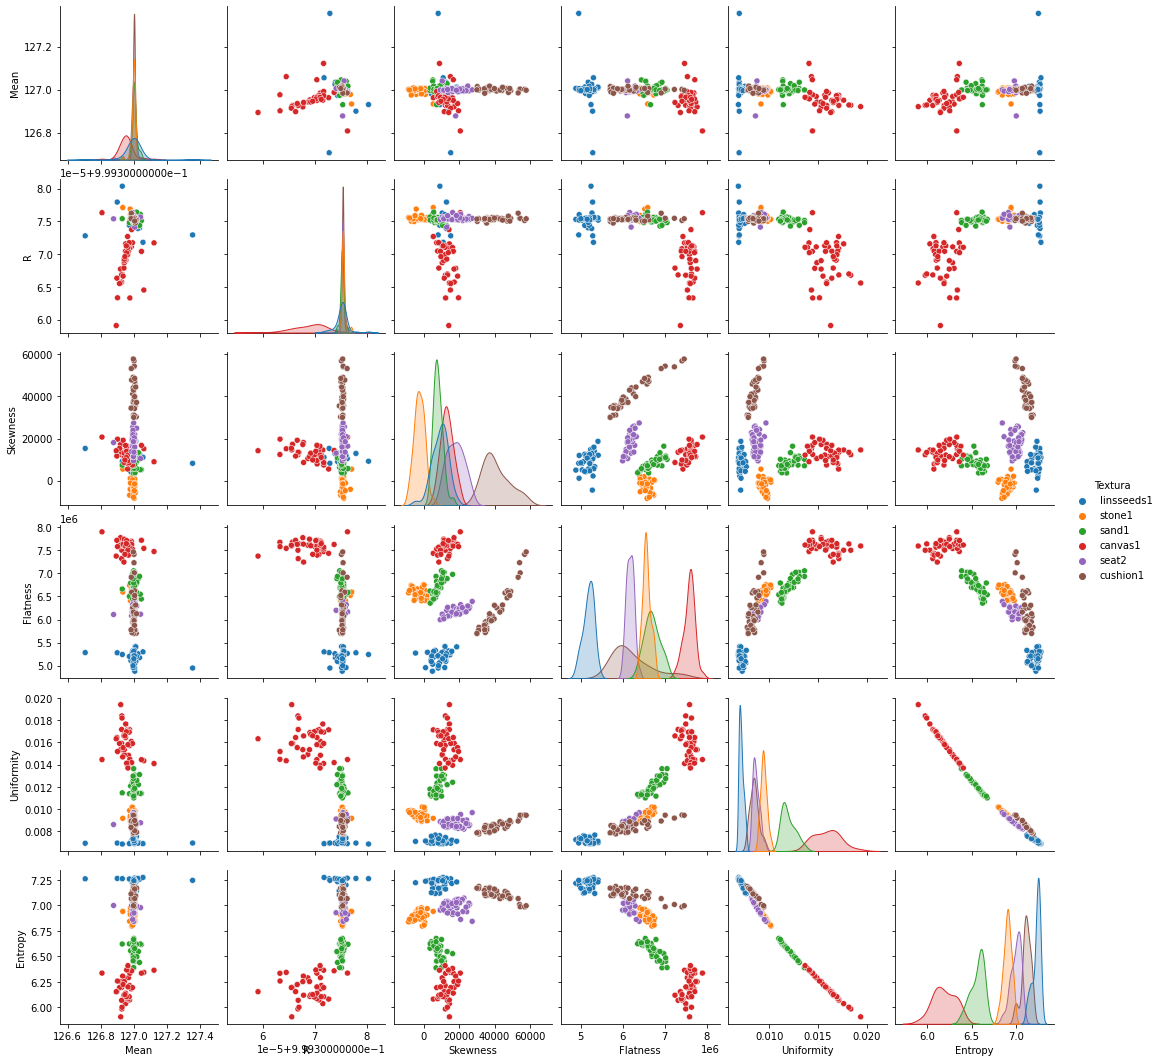

In [29]:
distancia=500
angulo=0
datos=procesar_carpeta_texturas(dir_base_texturas, distancia, angulo)
df = pd.DataFrame(datos[1:], columns=datos[0])
sn.pairplot(df, hue='Textura')

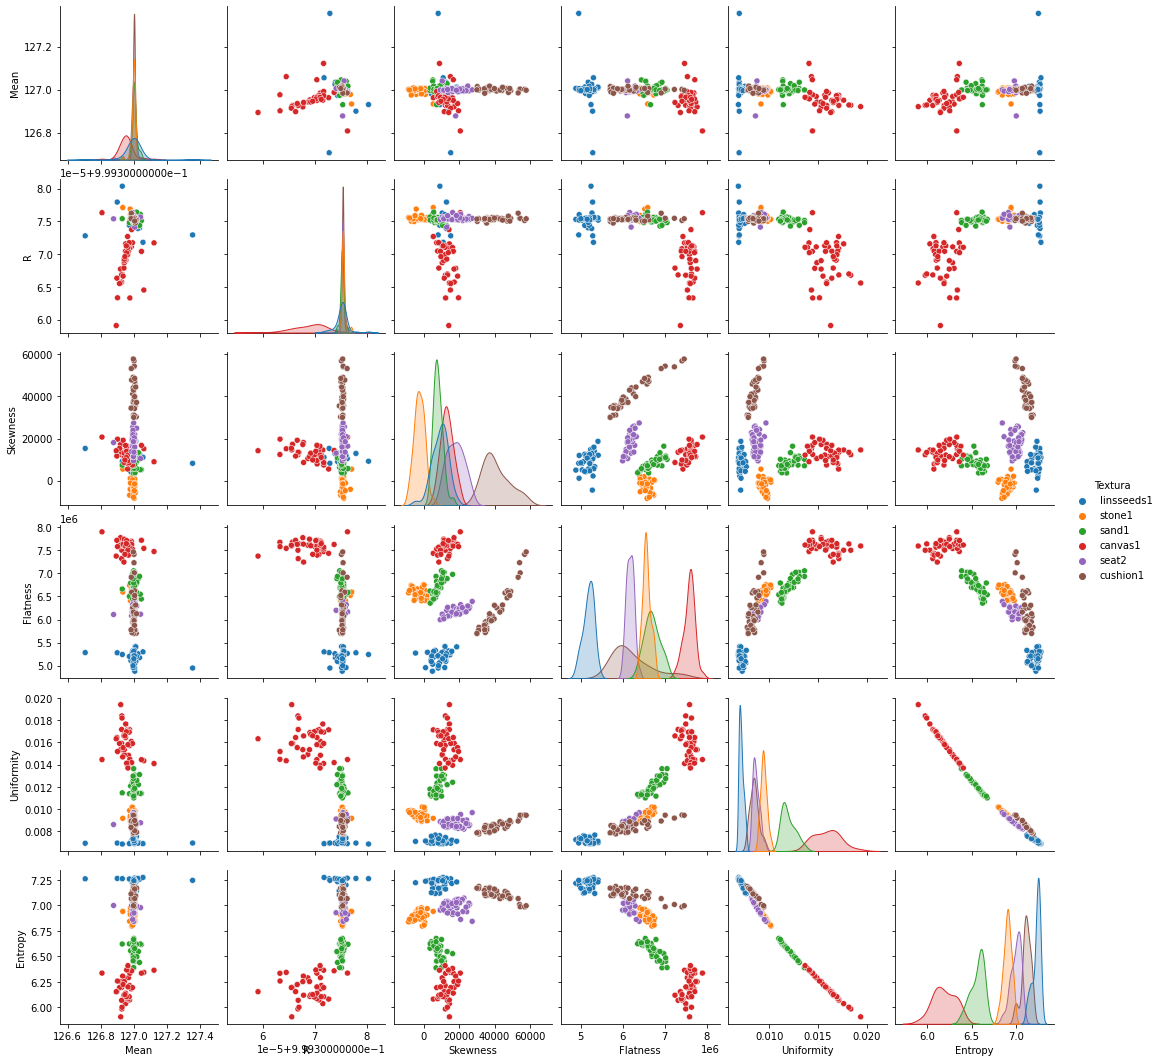

In [30]:
distancia=50
angulo=np.pi/2
datos=procesar_carpeta_texturas(dir_base_texturas, distancia, angulo)
df = pd.DataFrame(datos[1:], columns=datos[0])
sn.pairplot(df, hue='Textura')

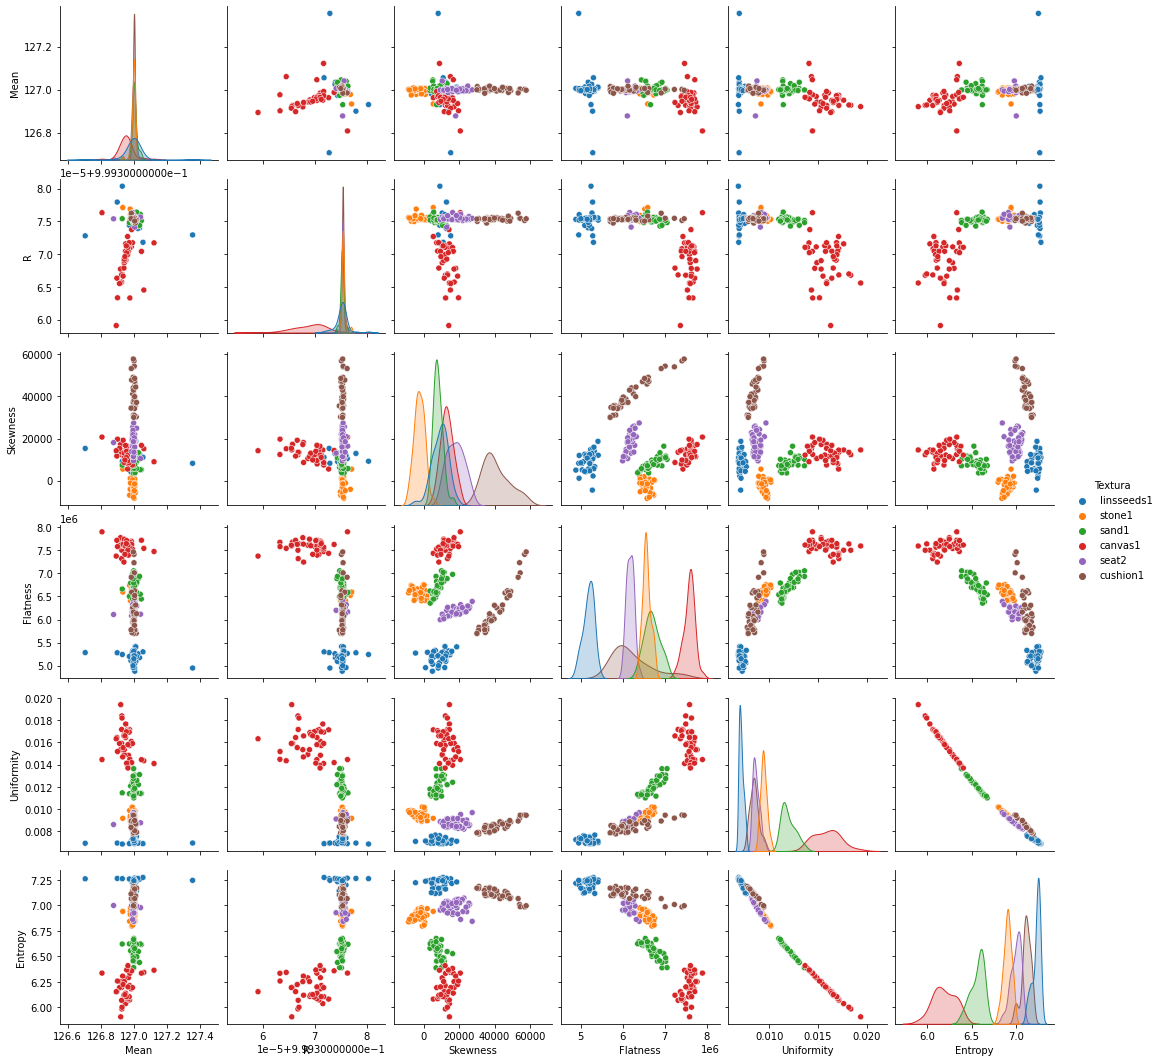

In [36]:
distancia=50
angulo=np.pi/4
datos=procesar_carpeta_texturas(dir_base_texturas, distancia, angulo)
df = pd.DataFrame(datos[1:], columns=datos[0])
sn.pairplot(df, hue='Textura')

####  ¿Existen descriptores que permiten discriminar las texturas de la base? En caso afirmativo, muestre cuáles se podrían usar. 

### 1.3. Implementar un clasificador de K vecinos más cercanos   
Ver:  
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html  

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html


a) Partir la base de imágenes en 2. De cada clase se usarán 20 imágenes para entrenamiento (conjunto de train) y se usarán las otras 20 imágenes para evaluar el clasificador (conjunto de test)        
b) Calcular sobre todas las imágenes de la base (train y test) las 2 características más relevantes (dos descriptores que se consideren buenos del paso (2) del ejercicio)   
Se armarán los arrays:    
* **X_train**:  array de tamaño (cantidad_imagenes_de_la_base/2, 2) donde cada fila tiene las características de una cierta imagen del conjunto de entrenamiento   
* **X_test**:  array de tamaño (cantidad_imagenes_de_la_base/2, 2) donde cada fila tiene las características de una cierta imagen del conjunto de test
* **y_train**: array de tamaño (cantidad_imagenes_de_la_base/2, 1) donde cada fila tiene la clase a la que corresponde una cierta imagen del conjunto de entrenamiento
* **y_test**: array de tamaño (cantidad_imagenes_de_la_base/2, 1) donde cada fila tiene la clase a la que corresponde una cierta imagen del conjunto de test    

c) Crear un clasificador de K vecinos más cercanos (considerar K entre 2 y 5)   
d) Entrenar con el conjunto de entrenamiento   
e) Evaluar el funcionamiento sobre el conjunto de test. 
* Mostrar la tasa de aciertos
* Mostrar la matriz de confusion de clases



Tasa de aciertos: 0.8083333333333333
Matriz de confusión:


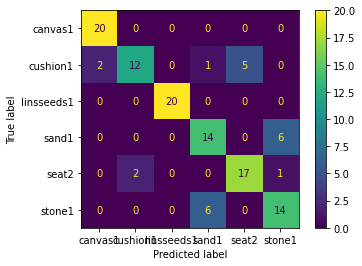

In [42]:
columnas_caracteristicas = df.columns[1:].tolist()
selected_columns = ["Flatness", "Skewness"]
X = df[selected_columns].values.astype(np.float64)
y = df['Textura'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)
clasificador = KNeighborsClassifier(n_neighbors=3)
clasificador.fit(X_train, y_train)
y_pred = clasificador.predict(X_test)
# Calcular la tasa de aciertos
accuracy = accuracy_score(y_test, y_pred)
print("Tasa de aciertos:", accuracy)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y))
cmd.plot()



## 2 Detección y matching de puntos SIFT

### 2.1 Escribir un programa que dadas dos imágenes calcule puntos SIFT y realice el matching de los mismos 
**Implementar mediante funciones de OpenCV**  
Ver:   
https://docs.opencv.org/4.7.0/da/df5/tutorial_py_sift_intro.html   
https://docs.opencv.org/4.7.0/dc/dc3/tutorial_py_matcher.html   


**Explicar todos los parámetros de las funciones usadas y el criterio tomado para elegir cada uno de ellos**

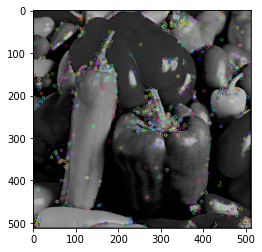

In [47]:

img = cv2.imread(dir_base_imagenes+"peppers_dark.png")

gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp = sift.detect(gray,None)

img=cv2.drawKeypoints(gray,kp,img)

plt.imshow(img)
plt.show()



In [ ]:
img1 = cv.imread('box.png',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('box_in_scene.png',cv.IMREAD_GRAYSCALE) # trainImage
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

### 2.2 Mostrar el resultado de detectar y matchear para las imágenes "peppers_dark" y "peppers_rotada"   
**a) Mostrar gráficamente los matches   
b) Para los 3 matches más fuertes, mostrarlos en las imágenes y analizar los descriptores correspondientes (escala, ángulo, histograma de orientaciones locales, etc)    
c) Algunos de los matches son erroneos (los puntos matcheados no corresponden a la misma zona de la imagen). Analizar, como en (b) alguno de estos matches erroneos.**

### 2.3 Estimar, de forma robusta, la homografía entre las imágenes a partir de los matches  

A partir de la correspondencia entre puntos característicos, es posible determinar la transformación plana que relaciona las dos imágenes pero, como se vio en 2.2, no hay garantía que todas las correspondencias del matching sean buenas. Es necesario entonces estimar la homografía de forma robusta reconociendo cuáles son las correspondencias buenas (las llamaremos inliers) y descartando las malas (que llamaremos outliers).    
El cálculo robusto de la homografía se implementará mediante RANSAC.    

Para esta parte puede ser interesante ver las secciones 4.7 y 4.8 del libro:    
Multiple View Geometry in Computer Vision (Second Edition)    
Richard Hartley and Andrew Zisserman, Cambridge University Press, March 2004.    
https://www.robots.ox.ac.uk/~vgg/hzbook/



   
**Investigar RANSAC.    
Explicar la idea general de RANSAC y su aplicación para la estimación robusta de una homografía** 

#### Implementar la estimación de una homografía usando RANSAC

In [ ]:
def estimar_homografia_con_ransac(puntos_ori, puntos_dst, iteraciones, umbral_distancia):
    '''
    Estima una homografia usando RANSAC

    Parameters
    ----------
    puntos_ori : array Nx2 de coordenadas de puntos
        Puntos origen.
    puntos_dst : array Nx2 de coordenadas de puntos
        Puntos destino.
    iteraciones : int
        Cantidad de repeticiones del muestreo y calculo de posibles homografias.
    umbral_distancia : double
        Umbral para evaluar la distancia entre un punto destino y su 
        correspondiente proyectado por la homografia en evaluacion.

    Returns
    -------
    H : array 3x3
        Homografia estimada.
    indices_inliers : array
        Lista de los indices que resultaron inliers de H.
    indices_outliers : array
        Lista de los indices que resultaron outliers de H.

    '''
    
    # COMPLETAR
    
    
    return H, indices_inliers, indices_outliers

#### Estimar la homografía para las correspondencias encontradas entre las imágenes "peppers_dark" y "peppers_rotada"   
**a) Mostrar los resultados numéricos (H,cantidad de inliers y outliers, etc.)   
b) Mostrar gráficamente las correspondencias inliers y outliers** 

### 2.4 Aplicación: Reconocimiento automático de productos de supermercado

El objetivo es reconocer automáticamente y encontrar la orientación en la imagen de productos de supermercado cuando éstos son mostrados a la cámara utilizando matching de puntos SIFT.   

**Imágenes base**  
Obtener las imágenes de productos en páginas web de supermercados.  Se usarán 4 imágenes base de productos que a su vez tengan en su casa.  

**Imágenes a reconocer**   
Se adquirirán 6 imágenes de cada uno de los productos reales con variación de distancia, orientación y posición.  Se adquirirán además 6 imágenes sin ningún producto.     

A modo de ejemplo se incluyen dos imágenes base de productos e imágenes a reconocer (ver imagenes/productos).


**Se implementará un programa que**, dada una imagen a reconocer:

a) Determine si está presente o no alguno de los productos de las imágenes base  
b) En caso de haber un producto presente en la imágen se debe   
* indicar cuál es el producto 
* estimar la homografía entre producto base y producto real
* mostrar, sobre la imagen a reconocer, el recuadro del producto calculado usando la homografía


